![Banner challenge](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner1TelecomX_readme.png)


##📌 Bibliotecas.

In [69]:
%%capture
!pip install -U plotly kaleido

In [70]:
import pandas as pd
import requests
from pandas import json_normalize
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
##Para utilizar imagen de repositorio.
import urllib.request
from PIL import Image


---

#💾  **Extracción de Datos.**



![imagen banner extracción de datos](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/Banner%20Extracci%C3%B3n%20de%20datos.png)

In [71]:
url = "https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [72]:
!pip install mplcursors

---
#🧰 **Transformación.**

![Banner sección transformación](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/Banner%20transformacion%20de%20datos.png)

##📌 **Diccionario de Datos.**


*   customerID: número de identificación único de cada cliente
*   Churn: si el cliente dejó o no la empresa
*   gender: género (masculino y femenino)
*   SeniorCitizen: información sobre si un cliente tiene 65 años o más
*   Partner: si el cliente tiene pareja o no
*   Dependents: si el cliente tiene dependientes o no
*   tenure: meses de contrato del cliente
*   PhoneService: suscripción de servicio telefónico
*   MultipleLines: suscripción a más de una línea de teléfono
*   InternetService: suscripción a un proveedor de internet
*   OnlineSecurity: suscripción adicional de seguridad online
*   OnlineBackup: suscripción adicional de backup online
*   DeviceProtection: suscripción adicional de protección en el dispositivo
*   TechSupport: suscripción adicional de soporte técnico, menos tiempo de espera
*   StreamingTV: suscripción de TV por cable
*   StreamingMovies: suscripción de streaming de películas
*   Contract: tipo de contrato
*   PaperlessBilling: si el cliente prefiere recibir la factura online
*   PaymentMethod: forma de pago
*   Charges.Monthly: total de todos los servicios del cliente por mes
*   Charges.Total: total gastado por el cliente

##🛠️ **Normalización de Columnas.**

In [73]:
df_telecomX_normalizado = pd.json_normalize(data)
df_telecomX_normalizado.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##🛠️ **Identificación de Inconsistencias en Datos.**

In [74]:
# Código para Verificación de Valores Únicos por Columna.
print(f"📝Resumen para Verificación de Valores Únicos por Columna.\n")
for col in df_telecomX_normalizado.columns:
  print(f"🟣 Columna: '{col}': {df_telecomX_normalizado[col].nunique()}\n")

  if df_telecomX_normalizado[col].nunique() < 50: # Imprima los valores solamente si no hay muchos
    print(f"\t✏️ valores = {df_telecomX_normalizado[col].unique()}\n")
  print('-' * 50)  # Línea divisoria para mejor visualización

📝Resumen para Verificación de Valores Únicos por Columna.

🟣 Columna: 'customerID': 7267

--------------------------------------------------
🟣 Columna: 'Churn': 3

	✏️ valores = ['No' 'Yes' '']

--------------------------------------------------
🟣 Columna: 'customer.gender': 2

	✏️ valores = ['Female' 'Male']

--------------------------------------------------
🟣 Columna: 'customer.SeniorCitizen': 2

	✏️ valores = [0 1]

--------------------------------------------------
🟣 Columna: 'customer.Partner': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.Dependents': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.tenure': 73

--------------------------------------------------
🟣 Columna: 'phone.PhoneService': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'phone.MultipleLines': 3

	✏️ valores = ['No' 'Yes' 'No phone service']

------------

In [75]:
# Verificando si hay duplicados
print(f"📝 Resumen de Verificación de Datos duplicados y Núlos.\n")
duplicados = df_telecomX_normalizado.duplicated().sum()
print(f"🟣 Número de líneas duplicadas:\n")

if  duplicados:
    print(f"\t🔸{duplicados}")
else:
    print("   ✅ No hay registros duplicados.")


# Verificando si hay valores Nulos
valores_nulos = df_telecomX_normalizado.isnull().sum()
valores_nulos.name = 'Valores Nulos'
valores_nulos_filtrados = valores_nulos[valores_nulos > 0]

print(f"\n🟣 Valores nulos por columna:\n")
if not valores_nulos_filtrados.empty:
    for columna, cantidad in valores_nulos_filtrados.items():
        print(f"\t🔸 {columna}: {cantidad}")
else:
    print("   ✅ No hay columnas con datos nulos.\n")
    display(valores_nulos)


📝 Resumen de Verificación de Datos duplicados y Núlos.

🟣 Número de líneas duplicadas:

   ✅ No hay registros duplicados.

🟣 Valores nulos por columna:

   ✅ No hay columnas con datos nulos.



,Valores Nulos
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [76]:
#código para calcular valores sin registro
valores_blanco_vacio = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.strip() == '').sum()
valores_blanco_vacio.name = 'Registro en blanco'
print("\n📝 Resumen para Registros en Blanco por Columna.\n")
display(valores_blanco_vacio)


📝 Resumen para Registros en Blanco por Columna.



,Registro en blanco
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [77]:
df_telecomX_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [78]:
#1. Columna 'SeniorCitizen'(0,1)(objet)Se puede convertir sus valores a 'Yes' o 'No'
#2. Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar
#3. Columna 'PaymentMethod' remover (), reemplazar espacios por guion.
#4. Columna 'Charges.Total' convertir a tipo float64.
#5. Columnas 'Churn' ''
#6. Tratamiento preventivo para columnas tipo texto: Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
#7. Tratamiento preventivo para columnas con caracteres numericos y conversión tipo float64.

##🛠️ **Manejo de Inconsistencias en Datos.**

In [79]:
#Tratamiento mínimo para columnas tipo cadena de texto.
#Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
df_telecomX_normalizado = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.lower())

In [80]:
#Retornamos formato de id_cliente.
df_telecomX_normalizado['customerID'] = df_telecomX_normalizado['customerID'].astype(str).str.upper()

In [81]:
#Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar.
#Son las columnas cuyos registros deseamos unir con un guion.
columnas_espacios = ['account.Contract','account.PaymentMethod','internet.InternetService']
for col in columnas_espacios:
  df_telecomX_normalizado[col] = df_telecomX_normalizado[col].str.replace(' ','-')

In [82]:
#Columna 'Charges.Monthly','Charges.Total' Limpieza preventiva de caracteres menos numericos y el punto.
columnas_numericas = ['account.Charges.Monthly','account.Charges.Total']
for col in columnas_numericas:
  df_telecomX_normalizado[col] = pd.to_numeric(df_telecomX_normalizado[col].astype(str).str.replace(r'[^0-9.]','', regex=True), errors='coerce')

In [83]:
# Eliminar filas vacias en columna 'Churn'
df_telecomX_limpio = df_telecomX_normalizado[df_telecomX_normalizado['Churn'].str.strip() != ''].copy()
df_telecomX_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   object 
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   object 
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

In [84]:
# Vacíos o en blanco
conteo_vacios = df_telecomX_limpio.apply(lambda x: x.astype(str).str.strip() == '').sum()

###🛠️ **Cuentas Diarias.**

In [85]:
#Creo columna Cuentas_diarias.
df_telecomX_limpio['Cuentas_diarias'] = df_telecomX_limpio['account.Charges.Monthly']/30
df_telecomX_limpio['Cuentas_diarias']

,Cuentas_diarias
0,2.186667
1,1.996667
2,2.463333
3,3.266667
4,2.796667
...,...
7262,1.838333
7263,2.836667
7264,1.676667
7265,2.261667


In [86]:
columna_chargesM_cuenta_diaria = df_telecomX_limpio[['account.Charges.Monthly','Cuentas_diarias']].isna().sum()
print(columna_chargesM_cuenta_diaria)


account.Charges.Monthly    0
Cuentas_diarias            0
dtype: int64


###🛠️ **Estandarización y Transformación de Datos.**

####🔨 **Para Análisis Exploratorio.**

In [87]:
#Traducción de columnas.
df_telecomX_limpio.columns = ['id_cliente','evasion','genero','a_mayor','pareja','dependientes','antiguedad','telefonia',
              'multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','contrato',
              'factura_online','m_pago','cargo_mensual','cargo_total','cuenta_diaria']


In [88]:
#Transformamos valores binarios solo para análisis exploratorio.
df_telecomX_limpio['a_mayor'] = df_telecomX_limpio['a_mayor'].replace({'1':'si','0':'no'})
df_telecomX_limpio['a_mayor']

,a_mayor
0,no
1,no
2,no
3,si
4,si
...,...
7262,no
7263,no
7264,no
7265,no


In [89]:
#Traduccion de texto al español.
columnas_datos_si_internet= ['evasion','pareja','dependientes','telefonia','multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','factura_online']
for col in columnas_datos_si_internet:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes':'si','No internet service':'no-aplica'})

#Traduccion en columna contrato.
df_telecomX_limpio['contrato'] = df_telecomX_limpio['contrato'].replace({'one-year':'anual','month-to-month':'mensual','two-year':'bianual'})
#Traduccion en columna m_pago.
df_telecomX_limpio['m_pago'] = df_telecomX_limpio['m_pago'].replace({'mailed-check':'cheque-por-correo','electronic-check':'cheque-electronico','credit-card-(automatic)':'cargo-automatico-tc',
                                                                  'bank-transfer-(automatic)':'cargo-automatico-cta-bancaria'})

In [90]:
display(df_telecomX_limpio.head(2))

,id_cliente,evasion,genero,a_mayor,pareja,dependientes,antiguedad,telefonia,multilinea,internet,...,proteccion,soporte,tv,peliculas,contrato,factura_online,m_pago,cargo_mensual,cargo_total,cuenta_diaria
0,0002-ORFBO,no,female,no,si,si,9,si,no,dsl,...,no,si,si,no,anual,si,cheque-por-correo,65.6,593.3,2.186667
1,0003-MKNFE,no,male,no,no,no,9,si,si,dsl,...,no,no,no,si,mensual,no,cheque-por-correo,59.9,542.4,1.996667


####🔧 **Para Modelado.**

In [91]:
"""
#Cambio a datos binarios.
col_dato_binario = ['desersion','pareja','dependientes','telefonia','factura_online']
for col in col_dato_binario:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes': 1, 'no': 0}).astype('int64')

  print(f"✅ {df_telecomX_limpio[col].value_counts(dropna=False)}\n")
"""
print()

---

#📊 **Carga y análisis.**

![Banner sección carga y análisis](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner%20carga%20y%20an%C3%A1lisis.png)

##✏️ **Análisis Descriptivo.**
--

* Hay 11 registros en cargo_total que no aparecen en las otras columnas.

* Se recomienda verificar de qué manera puede recalcularse el valor de esos registros faltantes. Por ejemplo, si el contrato es mensual, es posible que el cargo_total coincida con el cargo_mensual.

In [92]:
display(df_telecomX_limpio.describe())

,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,2.158723
std,30.090047,2266.771362,1.003002
min,18.250000,18.800000,0.608333
25%,35.500000,401.450000,1.183333
50%,70.350000,1397.475000,2.345000
75%,89.850000,3794.737500,2.995000
max,118.750000,8684.800000,3.958333


🟣 **Interpretar la Distribución.**

* Si mean ≈ 50%, podrías estar frente a una distribución simétrica.

* Si mean > 50%, distribución sesgada a la izquierda (cola larga hacia la izquierda).

* Si mean < 50%, distribución sesgada a la derecha (cola larga hacia la derecha).

🟣 **Rango y dispersión.**

* max - min: te da el rango total de valores.

* std: cuanto mayor sea, más dispersos están los datos respecto al promedio.

* Si std es muy grande respecto a la mean, indica alta variabilidad.

🟣 Cuartiles.

* Puedes ver la concentración de los datos:

* Si Q3 - Q1 (llamado rango intercuartílico) es pequeño: los datos están más concentrados.

* Si es grande: hay alta dispersión entre el 25% y el 75% central de los datos.

**Escala de Apreciación del Coeficiente de Variación.**


| CV (%)        | Nivel de dispersión | Descripción sugerida                                            |
| ------------- | ------------------- | --------------------------------------------------------------- |
| **0% – 15%**  | Muy baja dispersión | Los datos son altamente homogéneos. Muy poca variación.         |
| **15% – 30%** | Baja dispersión     | Los datos son bastante consistentes. Variación limitada.        |
| **30% – 50%** | Moderada dispersión | Hay diferencias visibles entre los valores.                     |
| **50% – 70%** | Alta dispersión     | Alta variabilidad. Los valores están bastante separados.        |
| **> 70%**     | Muy alta o extrema  | Dispersión muy marcada. El promedio deja de ser representativo. |


#####🏷️ **Interpretación.**

* **Variable antiguedad.**
  El promedio es de 32.37 meses, la mediana es de 29 meses y la desviación estándar es 24.55 meses.

  Esto sugiere una asimetría positiva leve, donde algunos valores altos podrían estar elevando la media.

  EL coeficiente de variación (CV) es de 75.84%, lo que indica una dispersión muy alta.
  
  Interpretación: La variabilidad en la antigüedad de los clientes es tan marcada que el promedio deja de ser un valor representativo del conjunto.

* **Variable cargo_mensual.**

  El promedio es de \$64.76, la mediana es \$70.35 y la desviación estándar es \$30.09.

  Esto sugiere una asimetría negativa leve, donde algunos valores pequeños podrían estar reduciendo la media.

  El coeficiente de variación (CV) es de 46.46%, lo que indica una dispersión moderadamente alta.
  
  Interpretación: los cargos mensuales varían considerablemente entre clientes.


* **Variable cargo_total.**

  El promedio es de $2,279.73, la mediana es \$1,394.55 y la desviación estándar es \$2,266.79.

  La diferencia notable entre la media y la mediana sugiere una asimetría positiva alta, donde algunos valores extremos elevan el promedio.

  El CV es de 99.43%, lo que indica una alta dispersión.
  
  Interpretación: el total acumulado que pagan los clientes varía ampliamente entre usuarios.

* **Variable cuenta_diaria.**

  El promedio diario es de \$2.16 , la mediana  \$2.35, y la desviación estándar es \$1.00.

  La diferencia sutil entre la media y la mediana sugiere una asimetría negativa muy leve, donde algunos valores bajos pueden estar ligeramente reduciendo la media.

  El CV es de 46.30%, lo que también indica una dispersión moderadamente alta.
  
  Interpretación: los cargos diarios no son uniformes y varían de forma significativa entre clientes.

#####🏷️**Gráfico Boxplot.**

In [93]:
#Cambio de dato object a numeric en columna antiguedad.
df_telecomX_limpio['antiguedad'] = pd.to_numeric(df_telecomX_limpio['antiguedad'],errors='coerce')
# Calcular el cargo_total donde falta.
# Calcular cargo_total donde falte usando antigüedad en meses (convertida a días) y cuenta_diaria
df_telecomX_limpio['cargo_total'] = df_telecomX_limpio.apply(
    lambda row: (row['antiguedad'] * 30) * row['cuenta_diaria'] if pd.isnull(row['cargo_total']) else row['cargo_total'],
    axis=1
)

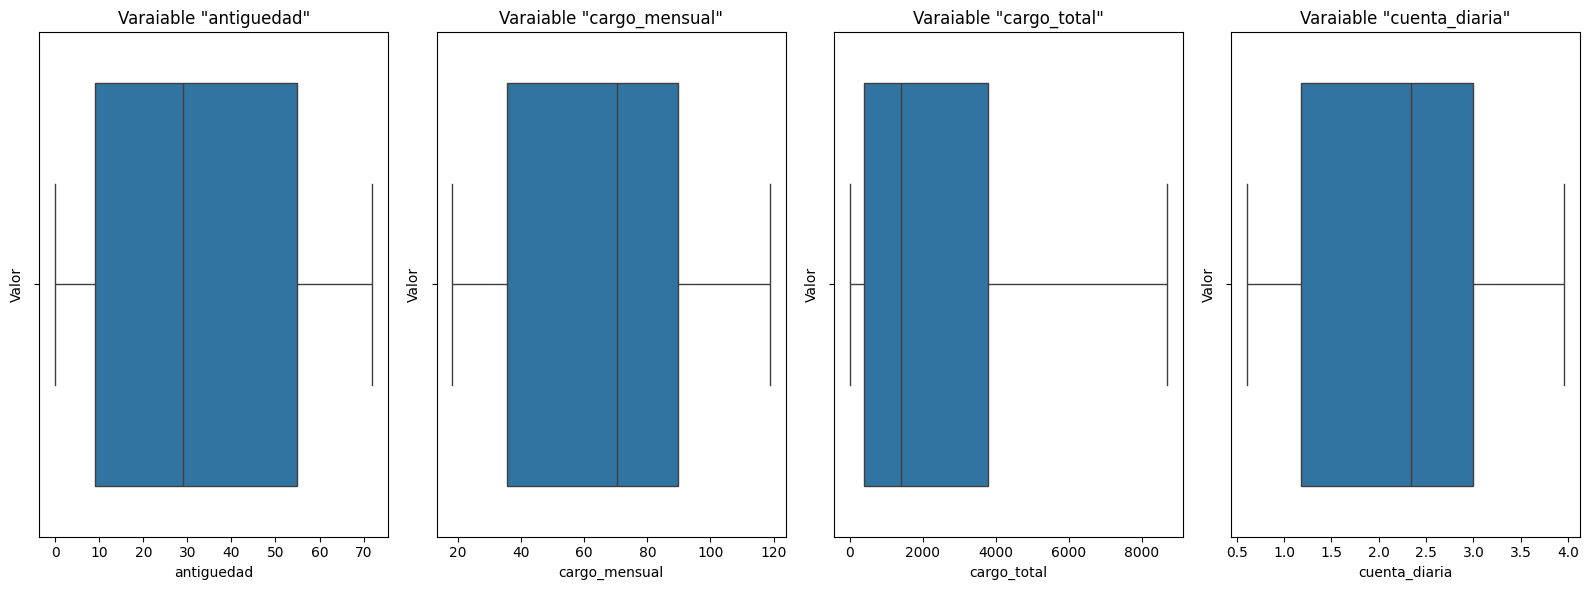

In [94]:
import mplcursors

#Código para boxplot.

# Supongamos que df es tu DataFrame y tienes las columnas 'var1', 'var2', 'var3', 'var4'
# que quieres graficar como boxplots

# Lista de las columnas que contienen los valores numéricos
variables = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']

# Crear un lienzo con 4 subgráficos (1 columna, 4 filas)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))

# Itera sobre las columnas y genera un boxplot para cada una
for i, var in enumerate(variables):
    sns.boxplot(x=df_telecomX_limpio[var], ax=axes[i])
    axes[i].set_title(f'Varaiable "{var}"')
    axes[i].set_ylabel('Valor')

    # Agregar interactividad para mostrar los datos al pasar el cursor
    mplcursors.cursor(axes[i], hover=True)

# Ajustar el layout para que los gráficos no se sobrepongan
plt.tight_layout()

# Guardar la figura .
plt.savefig("boxplot_variables_numericas.png", dpi=300, bbox_inches='tight')

# Mostrar los gráficos
plt.show()


##✏️ **Análisis Exploratoria (EDA).**

#####🏷️**Variable evasion.**

In [95]:

#Código para distribución de frecuencia.
variables_categóricas = ['evasion', 'genero', 'a_mayor', 'pareja',
       'dependientes','telefonia', 'multilinea', 'internet',
       'seguridad', 'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas',
       'contrato', 'factura_online', 'm_pago','cargo_total']

#Contiene la distribución de frecuencia de cada variable categórica.
frecuencia_variable_categorica = {}

for col in variables_categóricas:
  frecuencia = df_telecomX_limpio[col].value_counts()
  participacion = df_telecomX_limpio[col].value_counts(normalize=True)  # para ver % participación
  frecuencia_variable_categorica[col] = pd.concat([frecuencia,participacion],axis=1)


In [96]:
#Código  para calcular distribución de frecuencia absoluta y relativa para la columna evasión.
print(f"🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.\n")
df_telecomX_limpio['evasion'].astype(str).str.replace('yes','si',regex=True)

frecuencia_variable_categorica['evasion'].columns = ['Absoluta','Relativa']
v_desersion = frecuencia_variable_categorica['evasion']
display(v_desersion)



🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.



,Absoluta,Relativa
evasion,,
no,5174,0.73463
si,1869,0.26537


In [97]:
# Reemplazar 'yes' por 'si' en la columna 'evasion' (si es necesario)
df_telecomX_limpio['evasion'] = df_telecomX_limpio['evasion'].astype(str).str.replace('yes', 'si', regex=True)


# Crear gráfico de barras con Plotly usando los datos de v_desersion
fig = go.Figure()

# Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
    x=v_desersion.index,  # Usar el índice como las categorías de 'evasion'
    y=v_desersion['Absoluta'],  # Usar la frecuencia absoluta de v_desersion
    marker_color=['green', 'blue'],  # Colores para las categorías
))

# Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
    title="Frecuencia Absoluta Variable 'Evasion'.",
    xaxis_title='Categorías de Evasión',
    yaxis_title='Frecuencia Absoluta',
    bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
    width=800,   # Ajustar el tamaño de la figura
    height=400,  # Ajustar la altura
    xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
)


#Guardar imagen interactiva.
fig.write_html("grafico_evasion.html", include_plotlyjs="cdn")

# Mostrar el gráfico
fig.show()


#####🏷️**Variables Numéricas.**

###### **Distribución de Frecuencia.**

In [98]:
##Recalculando datos en columna cargo_total.
df_telecomX_limpio.columns

Index(['id_cliente', 'evasion', 'genero', 'a_mayor', 'pareja', 'dependientes',
       'antiguedad', 'telefonia', 'multilinea', 'internet', 'seguridad',
       'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas', 'contrato',
       'factura_online', 'm_pago', 'cargo_mensual', 'cargo_total',
       'cuenta_diaria'],
      dtype='object')

In [99]:
df_telecomX_limpio['evasion'].unique()

array(['no', 'si'], dtype=object)

In [100]:
# Resumen estadístico por grupo de evasión.
df_telecomX_limpio.groupby('evasion')['antiguedad'].describe()


,count,mean,std,min,25%,50%,75%,max
evasion,,,,,,,,
no,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
si,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


In [101]:
df_telecomX_limpio_copy = df_telecomX_limpio.copy()
df_telecomX_limpio_copy['evasion'] = df_telecomX_limpio_copy['evasion'].map({'si': 1, 'no': 0})
display(df_telecomX_limpio_copy.describe())

,evasion,antiguedad,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,32.371149,64.761692,2279.734304,2.158723
std,0.441561,24.559481,30.090047,2266.794470,1.003002
min,0.000000,0.000000,18.250000,0.000000,0.608333
25%,0.000000,9.000000,35.500000,398.550000,1.183333
50%,0.000000,29.000000,70.350000,1394.550000,2.345000
75%,1.000000,55.000000,89.850000,3786.600000,2.995000
max,1.000000,72.000000,118.750000,8684.800000,3.958333


In [102]:
# Resumen estadístico por grupo de evasión.
resumen = df_telecomX_limpio_copy.groupby('evasion')['antiguedad'].describe()
#Lista para variables numéricas.
variables_numericas = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']


def resumen_estadistico(df, columna):
    resumen = df.groupby('evasion')[columna].describe()

    # Calcular IQR en meses y años.
    resumen['IQR'] = resumen['75%'] - resumen['25%']

    media_meses = resumen.loc[0,'mean'] - resumen.loc[1,'mean']
    media_años = media_meses / 12

    medianas_meses = resumen.loc[0,'50%'] - resumen.loc[1,'50%']

    print(f"🟡 Resumen estadístico para evasion vs {col}.\n")
    display(resumen)
    print(f"\n✏️ Diferencia de medias: {media_meses:.2f} \n")
    print(f"✏️ Diferencia de medianas: {medianas_meses:.2f} \n\n\n")


for col in variables_numericas:
  resumen_estadistico(df_telecomX_limpio_copy, col)


🟡 Resumen estadístico para evasion vs antiguedad.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0,46.0
1,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0,27.0



✏️ Diferencia de medias: 19.59 

✏️ Diferencia de medianas: 28.00 



🟡 Resumen estadístico para evasion vs cargo_mensual.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75,63.30
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35,38.05



✏️ Diferencia de medias: -13.18 

✏️ Diferencia de medianas: -15.22 



🟡 Resumen estadístico para evasion vs cargo_total.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45,3689.95
1,1869.0,1531.796094,1890.822994,18.85,134.5,703.550,2331.30,8684.80,2196.80



✏️ Diferencia de medias: 1018.12 

✏️ Diferencia de medianas: 975.98 



🟡 Resumen estadístico para evasion vs cuenta_diaria.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,2.042171,1.036422,0.608333,0.836667,2.1475,2.946667,3.958333,2.110000
1,1869.0,2.481378,0.822202,0.628333,1.871667,2.6550,3.140000,3.945000,1.268333



✏️ Diferencia de medias: -0.44 

✏️ Diferencia de medianas: -0.51 





######**Boxplots.**

In [104]:
import plotly.express as px

# Boxplot horizontal: x = numérica, y = categórica
fig = px.box(
    df_telecomX_limpio_copy,
    x='antiguedad',          # antes estaba en y
    y='evasion',             # antes estaba en x
    color='evasion',
    orientation='h',         # fuerza orientación horizontal
    title='Boxplot de Antigüedad por Evasión (0: No, 1: Sí)',
    labels={'evasion': 'Evasión', 'antiguedad': 'Antigüedad (meses)'},
    color_discrete_map={0: 'green', 1: 'blue'}  # usa 0 y 1 si tu columna es numérica
)

# (Opcional) Asegurar orden 0 -> 1 en el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[0, 1])

# Tamaño de la figura
fig.update_layout(width=900, height=400)

# Guardar y mostrar
fig.write_html("grafico_evasion_vs_antiguedad_horizontal.html", include_plotlyjs="cdn")
fig.show()


In [136]:
#Gráfico para evasión vs cargo mensual.
# Boxplot horizontal: x = numérica, y = categórica
fig = px.box(
    df_telecomX_limpio_copy,
    x='cargo_mensual',          # antes estaba en y
    y='evasion',             # antes estaba en x
    color='evasion',
    orientation='h',         # fuerza orientación horizontal
    title='Boxplot de Cargo Mensual por Evasión (0: No, 1: Sí)',
    labels={'evasion': 'Evasión', 'cargo_mensual': 'Cargo Mensual'},
    color_discrete_map={0: 'green', 1: 'blue'}  # usa 0 y 1 si tu columna es numérica
)

# (Opcional) Asegurar orden 0 -> 1 en el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[0, 1])

# Tamaño de la figura
fig.update_layout(width=900, height=400)

# Guardar y mostrar
fig.write_html("grafico_evasion_vs_CMensual_horizontal.html", include_plotlyjs="cdn")
fig.show()


In [137]:
#Gráfico para evasión vs cargo total.
# Boxplot horizontal: x = numérica, y = categórica
fig = px.box(
    df_telecomX_limpio_copy,
    x='cargo_total',          # antes estaba en y
    y='evasion',             # antes estaba en x
    color='evasion',
    orientation='h',         # fuerza orientación horizontal
    title='Boxplot de Cargo Total por Evasión (0: No, 1: Sí)',
    labels={'evasion': 'Evasión', 'cargo_total': 'Cargo Total'},
    color_discrete_map={0: 'green', 1: 'blue'}  # usa 0 y 1 si tu columna es numérica
)

# (Opcional) Asegurar orden 0 -> 1 en el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[0, 1])

# Tamaño de la figura
fig.update_layout(width=900, height=400)

# Guardar y mostrar
fig.write_html("grafico_evasion_vs_CTotal_horizontal.html", include_plotlyjs="cdn")
fig.show()


In [138]:
#Gráfico para evasión vs cargo diario.
# Boxplot horizontal: x = numérica, y = categórica
fig = px.box(
    df_telecomX_limpio_copy,
    x='cuenta_diaria',          # antes estaba en y
    y='evasion',             # antes estaba en x
    color='evasion',
    orientation='h',         # fuerza orientación horizontal
    title='Boxplot de Cargo Diario por Evasión (0: No, 1: Sí)',
    labels={'evasion': 'Evasión', 'cuenta_diaria': 'Cargo Diario'},
    color_discrete_map={0: 'green', 1: 'blue'}  # usa 0 y 1 si tu columna es numérica
)

# (Opcional) Asegurar orden 0 -> 1 en el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[0, 1])

# Tamaño de la figura
fig.update_layout(width=900, height=400)

# Guardar y mostrar
fig.write_html("grafico_evasion_vs_CDiario_horizontal.html", include_plotlyjs="cdn")
fig.show()


######**Tendencia general evasión con variables numéricas.**


* Evasion vs antiguedad.

✔️ Patrón fuerte.

  Los clientes más recientes tienen más probabilidad de evadir, mientras que los clientes con más tiempo en la compañía tienden a permanecer.

* Evasion vs cargo_mensual.

✔️  Patrón fuerte.

Los clientes que no han desertado (0) tienden a tener facturas mensuales más bajas en promedio, pero con una mayor variabilidad en los cargos. Esto podría indicar que el grupo incluye tanto a clientes con planes bajos como a algunos con planes más altos.

Los clientes que han desertado (1), por otro lado, tienden a tener facturas mensuales más altas y más homogéneas, lo que podría ser un indicio de que los clientes que pagan más por sus servicios son más propensos a desertar.

* Evasion vs cargo_total.

✔️  Patrón fuerte.

Clientes no evasores, acumulan montos elevados por la influencia del tiempo facturando en la empresa. Clientes evasores en corto tiempo han acumulado montos totales con diferencias corta  975 y siendo que solo representan el 26.53% del universo de clientes.

Las diferencias entre sus medianas refuerzan la idea que clientes que permanecen han acumulado más que los evasores por factor tiempo, pero que la diferencia acumulada no es tan grande reforzando la idea que los clientes que evaden acumulan más en menos tiempo por que pagan más.

* Evasion vs cuenta_diaria.

✔️ Patrón fuerte.

Clientes que evaden con en promedio de cargos diarios mayor a los clientes que no evaden. Afirma la hipotesis que los clientes que evaden pobablemente tienen contratos más cortos o cancelan su servicio por obtener menor valor a un mismo precio.

#####🏷️**Variables Categóricas.**

######**Distribución de Frecuencia.**

In [108]:
#código para generar crosstab.
#Lista con variables categoricas para comparar distribución con la variable evasión.

variables_categóricas = ['genero', 'a_mayor', 'pareja',
       'dependientes','telefonia', 'multilinea', 'internet',
       'seguridad', 'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas',
       'contrato', 'factura_online', 'm_pago']

#Diccionario para guardar resumen de frecuencias por variables.
frecuencia_variable_categorica = {}

#Declaro función para construir crosstab.
def crosstab_churn(df, col_cat, col_target, margins_name="Total"):
    # 1) Tabla de conteos absolutos con fila y columna Total
    tabla_abs = pd.crosstab(
        df[col_cat],
        df[col_target],
        margins=True,
        margins_name=margins_name
    )

    # 2) Detectar columnas reales del target (excluir columna de totales)
    cols_target = [c for c in tabla_abs.columns if c != margins_name]

    # 3) Calcular % por fila solo para las columnas reales del target
    tabla_pct = tabla_abs[cols_target].div(
        tabla_abs[cols_target].sum(axis=1), axis=0
    ) * 100

    # 4) Agregar columnas de %
    for col in cols_target:
        tabla_abs[f"{col} (%)"] = tabla_pct[col].round(2)

    # 5) Agregar columna de verificación de suma de %
    tabla_abs["Suma %"] = tabla_abs[[f"{col} (%)" for col in cols_target]].sum(axis=1).round(2)

    return tabla_abs

for col in variables_categóricas:

  tabla = crosstab_churn(df_telecomX_limpio, col, 'evasion')
  frecuencia_variable_categorica[col] = tabla
  (f"🔢 Distribución evasion vs {col}.\n")
  display(tabla)
  print(f'\n\n')

evasion,no,si,Total,no (%),si (%),Suma %
genero,,,,,,
female,2549,939,3488,73.08,26.92,100.0
male,2625,930,3555,73.84,26.16,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
a_mayor,,,,,,
no,4508,1393,5901,76.39,23.61,100.0
si,666,476,1142,58.32,41.68,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
pareja,,,,,,
no,2441,1200,3641,67.04,32.96,100.0
si,2733,669,3402,80.34,19.66,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
dependientes,,,,,,
no,3390,1543,4933,68.72,31.28,100.0
si,1784,326,2110,84.55,15.45,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
telefonia,,,,,,
no,512,170,682,75.07,24.93,100.0
si,4662,1699,6361,73.29,26.71,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
multilinea,,,,,,
no,2541,849,3390,74.96,25.04,100.0
no phone service,512,170,682,75.07,24.93,100.0
si,2121,850,2971,71.39,28.61,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
internet,,,,,,
dsl,1962,459,2421,81.04,18.96,100.0
fiber-optic,1799,1297,3096,58.11,41.89,100.0
no,1413,113,1526,92.60,7.40,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
seguridad,,,,,,
no,2037,1461,3498,58.23,41.77,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1724,295,2019,85.39,14.61,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
respaldo,,,,,,
no,1855,1233,3088,60.07,39.93,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1906,523,2429,78.47,21.53,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
proteccion,,,,,,
no,1884,1211,3095,60.87,39.13,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1877,545,2422,77.50,22.50,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
soporte,,,,,,
no,2027,1446,3473,58.36,41.64,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1734,310,2044,84.83,15.17,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
tv,,,,,,
no,1868,942,2810,66.48,33.52,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1893,814,2707,69.93,30.07,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
peliculas,,,,,,
no,1847,938,2785,66.32,33.68,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1914,818,2732,70.06,29.94,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
contrato,,,,,,
anual,1307,166,1473,88.73,11.27,100.0
bianual,1647,48,1695,97.17,2.83,100.0
mensual,2220,1655,3875,57.29,42.71,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
factura_online,,,,,,
no,2403,469,2872,83.67,16.33,100.0
si,2771,1400,4171,66.43,33.57,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
m_pago,,,,,,
cargo-automatico-cta-bancaria,1286,258,1544,83.29,16.71,100.0
cargo-automatico-tc,1290,232,1522,84.76,15.24,100.0
cheque-electronico,1294,1071,2365,54.71,45.29,100.0
cheque-por-correo,1304,308,1612,80.89,19.11,100.0
Total,5174,1869,7043,73.46,26.54,100.0


######🔷 **Interpretación Distribución de Variables categóricas Respecto a la Variable Evasión.**


* Género – Posible candidata a eliminar – Distribución muy similar en ambas clases de churn (diferencia de evasión de 0.76 pp), lo que sugiere baja influencia predictiva.

* a_mayor – Relevante – Diferencia notable en la tasa de evasión entre categorías (adultos mayores: 41.68%, no adultos mayores: 23.61%), con una brecha de 18.07 pp, lo que indica fuerte asociación con la cancelación.

* pareja – Relevante – Diferencia importante en la tasa de evasión entre categorías (sin pareja: 32.96%, con pareja: 19.66%), con una brecha de 13.30 pp, lo que indica una asociación significativa con la cancelación.

* dependientes – Relevante – Diferencia significativa en la tasa de evasión entre categorías (sin dependientes: 31.28%, con dependientes: 15.45%), con una brecha de 15.83 pp, lo que indica fuerte asociación con la cancelación.

* telefonía – Relevante (estratégico) – La diferencia en la tasa de evasión entre categorías es pequeña (24.93% vs 26.71%, brecha de 1.78 pp), pero se mantiene en el modelo por su relevancia estratégica como producto principal de la empresa y por el potencial valor en interacciones con otras variables.

* multilinea – Posible candidata a eliminar (redundante con telefonía) – Subdivisión de “telefonía” (no phone service ≡ “no”); diferencia pequeña entre 1 o varias líneas (+3.57); riesgo de redundancia/multicolinealidad.

* internet – Relevante – Diferencias marcadas en la tasa de evasión según tipo de servicio. Brechas fibra vs DSL 22.93 pp; fibra vs sin internet 34.49 pp. Indica fuerte asociación con la cancelación, no debe eliminarse.

* seguridad – Relevante – Entre los clientes que tienen servicios de internet, quienes tienen servicios de seguridad o no tienen una diferencia marcada(27.16 pp). La categoría no internet service tiene evasión 7.40% en concordancia con quienes no tienen servicio de internet en la variable internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto causal directo.

* respaldo – Relevante – Entre clientes con internet, la breta es de 18.40 pp, diferencia marcada. La categoría “no internet service” presenta 7.40%, consistente con quienes no tienen internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto causal directo.

* protección – Relevante – Entre clientes con internet, la brecha es de 16.63 pp, diferencia marcada. La categoría “no internet service” es 7.40%, consistente con quienes no tienen internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto causal directo.

* soporte – Relevante – Entre clientes con internet, la brecha es de 26.47 pp, diferencia marcada. La categoría “no internet service” es 7.40%, consistente con quienes no tienen internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto causal directo.

* tv – Requiere prueba en el modelo –  Entre clientes con internet, la brecha es de 3.45 pp, efecto débil/moderado. La categoría “no internet service” es 7.40%, consistente con quienes no tienen internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto.

* películas – Requiere prueba en el modelo – Entre clientes con internet,brecha 3.74 pp, efecto débil/moderado. La categoría “no internet service” es 7.40%, consistente con quienes no tienen internet lo cual genera riesgo de redundancia/multicolinealidad. Variable depende de servicio de internet probable funcione como marcador de tipo de plan/combinación de servicios más que como efecto.

* contrato  – Relevante – Tasas de evasión muy dispares según contrato Brechas: mensual vs anual 31.44 pp; mensual vs bianual 39.88 pp.  Fuerte asociación con la cancelación (contratos de mayor plazo muestran menor evasión). Nota/Riesgo: probable correlación con antigüedad y con la composición del plan (posible redundancia/colinealidad). No implica causalidad directa.

* factura_online   – Relevante – Diferencia marcada en la tasa de evasión:17.24 pp fuerte asociación con la cancelación. Nota/Riesgo: probable correlación con tipo de contrato (mensual) y con la composición del plan/servicios (p. ej., tipo de internet), por lo que podría funcionar como marcador de adopción digital más que causalidad directa; considerar posible redundancia con variables relacionadas.

* m_pago — Relevante — Tasas de evasión muy dispares según método de pago:Brecha máxima 30.05 pp lo que sugiere fuerte asociación con la cancelación. Nota/Riesgo: probable correlación con tipo de contrato (mensual) y con adopción digital (p. ej., factura_online), por lo que podría existir redundancia con variables relacionadas.

---

######🔹  **Distribución evasion vs adulto mayor.**


In [109]:
df_a_mayor = pd.DataFrame(frecuencia_variable_categorica['a_mayor'])

# Crear gráfico de barras para a_mayor.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_a_mayor.index,  # Usar el índice como las categorías de 'evasion'
      y=df_a_mayor['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable adulto mayor.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Adulto Mayor',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_a_mayor.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs pareja.**

In [110]:
df_pareja = pd.DataFrame(frecuencia_variable_categorica['pareja'])

# Crear gráfico de barras para
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_pareja.index,  # Usar el índice como las categorías de 'evasion'
      y=df_pareja['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable pareja.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Pareja',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_pareja.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs dependientes.**

In [111]:
df_dependientes = pd.DataFrame(frecuencia_variable_categorica['dependientes'])

# Crear gráfico de barras para dependientes.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_dependientes.index,  # Usar el índice como las categorías de 'evasion'
      y=df_dependientes['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable dependientes.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Dependientes',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_dependientes.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹**Distribución evasion vs telefonia.**


In [112]:
df_dependientes = pd.DataFrame(frecuencia_variable_categorica['telefonia'])

# Crear gráfico de barras para dependientes.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_dependientes.index,  # Usar el índice como las categorías de 'evasion'
      y=df_dependientes['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable telefonia.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de telefonia',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_telefonia.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

######🔹  **Distribución evasion vs internet.**


In [113]:
df_internet = pd.DataFrame(frecuencia_variable_categorica['internet'])

# Crear gráfico de barras para internet.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_internet.index,  # Usar el índice como las categorías de 'evasion'
      y=df_internet['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79', '#FF7F00','#8B4513'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable internet.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Internet',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_internet.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs seguridad.**

In [114]:
df_seguridad = pd.DataFrame(frecuencia_variable_categorica['seguridad'])

# Crear gráfico de barras para seguridad.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_seguridad.index,  # Usar el índice como las categorías de 'evasion'
      y=df_seguridad['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable seguridad.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Seguridad',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_seguridad.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs respaldo.**

In [115]:
df_respaldo = pd.DataFrame(frecuencia_variable_categorica['respaldo'])

# Crear gráfico de barras para respaldo
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_respaldo.index,  # Usar el índice como las categorías de 'evasion'
      y=df_respaldo['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable respaldo.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Respaldo',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_respaldo.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs proteccion.**

In [116]:
df_proteccion = pd.DataFrame(frecuencia_variable_categorica['proteccion'])

# Crear gráfico de barras para protección.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_proteccion.index,  # Usar el índice como las categorías de 'evasion'
      y=df_proteccion['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable protección.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Protección',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_proteccion.html", include_plotlyjs="cdn")


  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs soporte.**

In [117]:
df_soporte = pd.DataFrame(frecuencia_variable_categorica['soporte'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_soporte.index,  # Usar el índice como las categorías de 'evasion'
      y=df_soporte['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00', '#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'soporte'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Soporte.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_soporte.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---
######🔹  **Distribución evasion vs tv.**

In [118]:
df_soporte = pd.DataFrame(frecuencia_variable_categorica['tv'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_soporte.index,  # Usar el índice como las categorías de 'evasion'
      y=df_soporte['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00', '#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'tv'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de tv.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_tv.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---
######🔹  **Distribución evasion vs peliculas.**

In [119]:
df_contrato = pd.DataFrame(frecuencia_variable_categorica['peliculas'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_contrato.index,  # Usar el índice como las categorías de 'evasion'
      y=df_contrato['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00', '#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'peliculas'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de películas.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_peliculas.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()




---


######🔹  **Distribución evasion vs contrato.**

In [120]:
df_contrato = pd.DataFrame(frecuencia_variable_categorica['contrato'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_contrato.index,  # Usar el índice como las categorías de 'evasion'
      y=df_contrato['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79', '#8B4513','#FF7F00'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'contrato'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Contrato.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_contrato.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs factura_online.**

In [121]:
df_factura_online = pd.DataFrame(frecuencia_variable_categorica['factura_online'])

# Crear gráfico de barras para factura_online
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_factura_online.index,  # Usar el índice como las categorías de 'evasion'
      y=df_factura_online['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79','#FF7F00'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable factura_online.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Factura Online.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_factura_online.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs m_pago.**



In [122]:
df_m_pago = pd.DataFrame(frecuencia_variable_categorica['m_pago'])

# Crear gráfico de barras para m_pago.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_m_pago.index,  # Usar el índice como las categorías de 'evasion'
      y=df_m_pago['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#00BFFF','#8B4513','#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable m_pago.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Cargo Mensual',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_m_pago.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

##✏️ Análisis de Correlación de Variables.

#####🏷️**Variables Numéricas.**

In [123]:
#Datos para la correlación.
#Lista para variables numéricas.
variables_numericas = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']
#df con datos de evasión alfanuméricos.
df_telecomX_limpio_copy['evasion'].unique()

array([0, 1])

In [124]:
from scipy.stats import pointbiserialr

**Análisis de Coeficiente:**
--

- \> 0 → a mayor valor de la variable numérica, más probabilidad de evasión.

- \< 0 → a mayor valor de la variable numérica, menos probabilidad de evasión.

- Cerca de 0 → casi sin relación.

**P-valor:**
--

- Si p_valor < 0.05 → la correlación es estadísticamente significativa (hay evidencia de que existe relación).

- Si p_valor ≥ 0.05 → la relación podría ser casual.

In [125]:
#Código para realizar análisis de correlación evasión vs variables numéricas.
resultados = []
for var in variables_numericas:
    coef, p_valor = pointbiserialr(df_telecomX_limpio_copy["evasion"], df_telecomX_limpio_copy[var])

    # Asignar emoji según dirección
    if coef > 0.05:
        emoji = "📈"  # relación positiva
    elif coef < -0.05:
        emoji = "📉"  # relación negativa
    else:
        emoji = "➖"  # relación casi nula

    resultados.append({
        "Variable": var,
        "Coeficiente": coef,        # valor original
        "P-valor": p_valor,         # valor original
        "Significativo": "✅" if p_valor < 0.05 else "❌",
        "Tendencia": emoji
    })

# Crear DataFrame de resultados
resultados_df = pd.DataFrame(resultados)

# Formato visual
resultados_df["Coeficiente"] = resultados_df["Coeficiente"].map(lambda x: f"{x:.3f}")
resultados_df["P-valor"] = resultados_df["P-valor"].map(lambda x: f"{x:.5f}")
print(f'📌 Análisis de Correlación de Variables "evasión" y "variables numéricas".\n')
display(resultados_df)


📌 Análisis de Correlación de Variables "evasión" y "variables numéricas".



,Variable,Coeficiente,P-valor,Significativo,Tendencia
0,antiguedad,-0.352,0.00000,✅,📉
1,cargo_mensual,0.193,0.00000,✅,📈
2,cargo_total,-0.198,0.00000,✅,📉
3,cuenta_diaria,0.193,0.00000,✅,📈


**Interpretación:**

* **Evasión vs Antigüedad.**
  Relación inversa, a menor valor de antiguedad del cliente mayor es la probabilidad que deje la empresa.

* **Evasión vs Cargo Mensual.**
  Relación directa, a mayor valor en el cargo mensual mayor la probabilidad que el cliente deje la empresa.

* **Evasión vs Cargo Total.**
  Relación inversa, a mayor valor en el cargo total en el cliente menor es la probabilidad que deja la empresa.

* **Evasión vs Cuenta Diaria.**
  Relación directa, a mayor valor en el cargo diario del cliente mayor es la probabilidad que deje la empresa.

**Interpretación**

- Para todas la variables numéricas es poco probable que el resultado observado sea producto del azar, por lo que tenemos evidencia para decir que probablemente sí existe una relación.

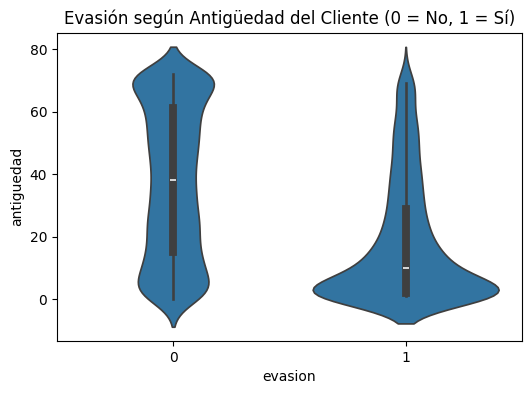

In [126]:
# variable "antiguedad"

plt.figure(figsize=(6,4))
sns.violinplot(x="evasion", y="antiguedad", data=df_telecomX_limpio_copy)
plt.title(f"Evasión según Antigüedad del Cliente (0 = No, 1 = Sí)")
plt.show()


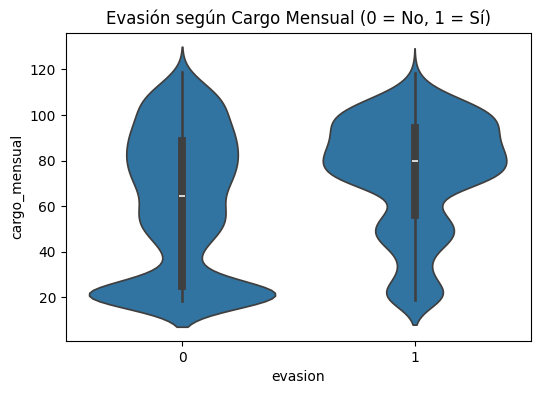

In [127]:
#Variable "cargo_mensual"

plt.figure(figsize=(6,4))
sns.violinplot(x="evasion", y="cargo_mensual", data=df_telecomX_limpio_copy)
plt.title(f"Evasión según Cargo Mensual (0 = No, 1 = Sí)")
plt.show()


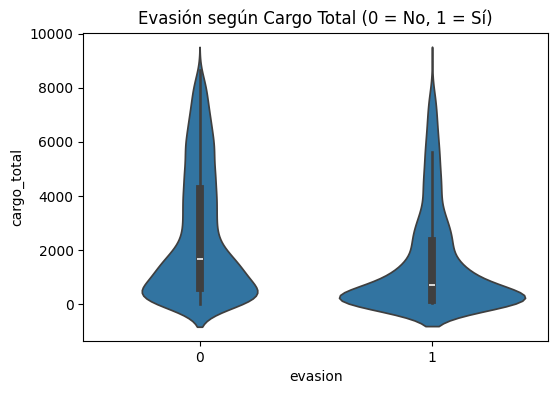

In [128]:
#Variable "cargo_total"

plt.figure(figsize=(6,4))
sns.violinplot(x="evasion", y="cargo_total", data=df_telecomX_limpio_copy)
plt.title(f"Evasión según Cargo Total (0 = No, 1 = Sí)")
plt.show()


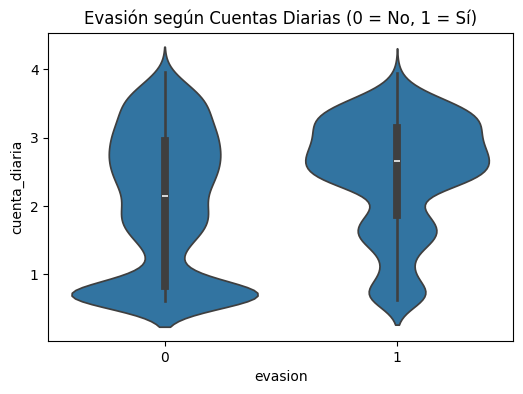

In [129]:
#Variable "cuenta_diaria"

plt.figure(figsize=(6,4))
sns.violinplot(x="evasion", y="cuenta_diaria", data=df_telecomX_limpio_copy)
plt.title(f"Evasión según Cuentas Diarias (0 = No, 1 = Sí)")
plt.show()


#####🏷️**Variables Categóricas.**

**Análisis de Chi-cuadrado de independencia.**
--

Sirve para saber si hay relación estadística entre dos variables categóricas.

No mide “dirección” como la correlación, pero sí te dice si hay dependencia.

**Interpretación:**

- p-valor < 0.05 → hay relación significativa.

- p-valor ≥ 0.05 → no hay evidencia de relación.

**Cramer’s V (opcional)**
--
Mide la fuerza de la relación entre 0 y 1:

| Valor V de Cramer | Interpretación |
| ----------------- | -------------- |
| **0.00 – 0.10**   | Muy débil      |
| **>0.10 – 0.25**  | Débil          |
| **>0.25 – 0.50**  | Moderada       |
| **>0.50**         | Fuerte         |


In [130]:
from scipy.stats import chi2_contingency

In [131]:
# Lista para guardar resultados
resultados = []

def etiqueta_intensidad(v):
    if pd.isna(v):
        return 'N/A'
    if v <= 0.10:
        return 'Muy débil'
    elif v <= 0.25:
        return 'Débil'
    elif v <= 0.50:
        return 'Moderada'
    else:
        return 'Fuerte'

for var, tabla in frecuencia_variable_categorica.items():
    # 1) Filtrar solo filas/columnas con conteos absolutos (quitar Totales y %)
    tabla_abs_sin_total = tabla.drop(index='Total', errors='ignore')
    tabla_abs_sin_total = tabla_abs_sin_total[
        [c for c in tabla_abs_sin_total.columns
         if not str(c).endswith('(%)') and c not in ('Suma %', 'Total')]
    ]

    # Si después de limpiar queda algo inválido, saltar
    if tabla_abs_sin_total.empty or tabla_abs_sin_total.shape[0] < 1 or tabla_abs_sin_total.shape[1] < 1:
        resultados.append({
            'Variable': var,
            'Chi-cuadrado': np.nan,
            'P-valor': np.nan,
            'Significativo': '❌',
            'Cramer_V': np.nan,
            'Intensidad': 'N/A'
        })
        continue

    # 2) Chi-cuadrado
    chi2, p, dof, expected = stats.chi2_contingency(tabla_abs_sin_total)

    # 3) Cramer's V (con resguardo si min(k-1, r-1) = 0)
    n = tabla_abs_sin_total.values.sum()
    r, k = tabla_abs_sin_total.shape
    denom = min(k - 1, r - 1)
    if denom <= 0 or n == 0:
        cramers_v_val = np.nan
    else:
        phi2 = chi2 / n
        cramers_v_val = np.sqrt(phi2 / denom)

    # 4) Guardar resultados (redondeo para mostrar, etiqueta según valor sin redondear)
    resultados.append({
        'Variable': var,
        'Chi-cuadrado': None if pd.isna(chi2) else round(chi2, 3),
        'P-valor': p,
        'Significativo': '✅' if (pd.notna(p) and p < 0.05) else '❌',
        'Cramer_V': None if pd.isna(cramers_v_val) else round(cramers_v_val, 3),
        'Intensidad': etiqueta_intensidad(cramers_v_val)
    })

# Convertir a DataFrame
resultados_df = pd.DataFrame(resultados)

# Formatear p-valor y ordenar por Cramer_V descendente (sin romper NaN)
resultados_df['P-valor'] = resultados_df['P-valor'].apply(lambda x: f"{x:.5f}" if pd.notna(x) else '')
resultados_df = resultados_df.sort_values(by='Cramer_V', ascending=False, na_position='last')

print('📌 Análisis de Correlación de Variables "evasión" y "variables categóricas".\n')
display(resultados_df)


📌 Análisis de Correlación de Variables "evasión" y "variables categóricas".



,Variable,Chi-cuadrado,P-valor,Significativo,Cramer_V,Intensidad
13,contrato,1184.597,0.00000,✅,0.410,Moderada
7,seguridad,849.999,0.00000,✅,0.347,Moderada
10,soporte,828.197,0.00000,✅,0.343,Moderada
6,internet,732.310,0.00000,✅,0.322,Moderada
15,m_pago,648.142,0.00000,✅,0.303,Moderada
8,respaldo,601.813,0.00000,✅,0.292,Moderada
9,proteccion,558.419,0.00000,✅,0.282,Moderada
11,tv,374.204,0.00000,✅,0.231,Débil
12,peliculas,375.661,0.00000,✅,0.231,Débil
14,factura_online,258.278,0.00000,✅,0.191,Débil


**Interpretación:**

- Observamos que con excepción de las variables 'genero' y 'telefonia', la mayoría de variables categoricas cuenta con evidencia estadística para decir que se asocian con la evasión de clientes y que son dependientes sin implicar causalidad. Si no que la distribución de la variable evasión cambia según el resto de las categorías. Y conocer los datos de estas variables me ayudarán a entender el fenómeno de la evasión.

- Respecto a la intensidad de la relación de dependencia destacan con mayor valor : contrato, seguridad, soporte, m_pago e internet pero ubicandose en un nivel de intensidad moderada alta, en términos generales.

- Respecto a la variable multilínea si bien tiene evidencia estadística, la intensidad de la relación es muy débil por lo que no aportaria valor al modelo.

---
#📄**Informe final: Análisis de Evasión de Clientes TELECOM X LATAM.**

![banner informe final](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner%20de%20informe.png)

##1️⃣ Introducción.

TelecomX LATAM empresa de servicios telefónicos enfrente un preocupante fenómeno: los clientes que cancelan sus servicios está aumentando.   Este fenómeno impacta directamente en la rentabilidad y el crecimiento de la empresa.  Para abordar el desafío hemos colaborado realizando un exhaustivo análisis con el objetivo de identificar de manera preliminar los factores que influyen en la desersión de sus clientes.   El análisis es parte de un Challenge de Data Science, en el que se pretende aplicar ténicas aprendidas referente al ETL (Extracción, Transformación y Carga) para preparar los datos, y se han desarrollado visualizaciones estratégicas para reconocer patrones y tendencias. La meta es proporcionar insight clave que puedan ser utilizados por el equipo de Telecom X LATAM para diseñar modelos predictivos y estratégias efectivas para reducir la tasa de evasión y mejorar la retención de los clientes.

##2️⃣ Metodología.

* Extracción de Datos.

 Los datos fueron obtenidos de la API de TelecomX LATAM, a través de un archivo JSON que contenía información esencial sobre los clientes. Este incluía datos demográficos, detalles sobre el tipo de servicio de contrato (telefonía, internet, u otros) y el estado de evasión de cada cliente. La API proporcionó un acceso eficiente y estructurado a esta información, permitiendo una extracción completa y precisa de los datos relevantes para el análisis.

* Transformación de Datos.

  Los datos fueron transformados para ser utilizados en el análisis. Visualizamos datos anidados por lo que normalizamos su contenido. Esto incluyó la normalización de datos para facilitar su comparación, la conversión de algunas variables a formatos adecuados y la imputación de valores faltantes. Se generaron variables adicionales como la antigüedad de los clientes y categorías basadas en sus servicios contratados, a fin de segmentar mejor la información.


* Análisis Exploratorio de Datos (EDA)

  Con la ayuda de la biblioteca pandas entre otras generamos preliminarmente un análisis descriptivo de las variables numéricas para explorar el comportamiento individual. Luego generamos crosstaba para comprender la distribución absoluta y relativa de las variables de interés enfocandonos en encontrar patrones sugirieran correlación significativa.

* Visualización Estratégica.

  Se desarrollaron visualizaciones detalladas para representar la distribución. Esto incluyó boxplots y gráficos de barras, para ayudar a visualizar la relación entre cada variable numérica y categórica con la tasa de evasión, así como los posibles factores de riesgo asociados.

* Generación de Insights.

  A partir de las tablas de frecuencia y las visualizaciones generadas, se extranjeron insights claves sobre los factores que podían estar contribuyendo a la evasión de clientes. Los hallazgos fueron resumidos y clasificados. Y con ellos extragimos un patrón global y recomendamos su uso para el modelado de predictivo y estratégias enfocadas en mejorar la retención de clientes.

* Carga de Datos.

  

## 3️⃣ **Resumen de Hallazgos.**

###🔵 **EDA: Frecuencia Absoluta y Relativa para Variable Evasión.**

| Evasión | Frecuencia (abs.) | Frecuencia relativa |
|---|---:|---:|
| No | 5,174 | 73.46% |
| Sí | 1,869 | 26.54% |

Gráfico 1.

![Gráfico 1](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable_evasion.png)



[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_evasion.html)


---

###🔵 **EDA: Hallazgos significativos — Variables categóricas.**



####🟢 **Relevante para el Modelo.**

| Variable                      | Justificación                                                                                                                                               |
| ----------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **a\_mayor**                  | Adultos mayores **41.68%** vs no adultos mayores **23.61%** (brecha **18.07 pp**): fuerte asociación con la cancelación.                                    |
| **pareja**                    | Sin pareja **32.96%** vs con pareja **19.66%** (brecha **13.30 pp**): asociación significativa.                                                             |
| **dependientes**              | Sin dependientes **31.28%** vs con dependientes **15.45%** (brecha **15.83 pp**): fuerte asociación.                                                        |
| **telefonía** *(estratégico)* | 24.93% (no) vs **26.71%** (sí), brecha **1.78 pp**; se mantiene por relevancia del producto y posibles interacciones.                                       |
| **internet**                  | Fibra **41.89%**, DSL **18.96%**, sin internet **7.40%**; brechas grandes (fibra–DSL **22.93 pp**, fibra–sin internet **34.49 pp**).                        |
| **contrato**                  | Mensual **42.71%**, anual **11.27%**, bianual **2.83%**; brechas **31.44** y **39.88 pp**. Riesgo: correlación con **antigüedad** y composición del plan.   |
| **factura\_online**           | No **16.33%** vs sí **33.57%** (brecha **17.24 pp**); posible marcador de adopción digital. Riesgo de redundancia con **contrato/método de pago/internet**. |
| **m\_pago**                   | Cheque-electrónico **45.29%** vs cargo automático TC **15.24%** (brecha máx. **30.05 pp**). Riesgo: correlación con **contrato** y **factura\_online**.     |



> **Interpretación:** porcentajes se refieren a la tasa de **evasión** (sí). Marcamos ↑ cuando la tasa está claramente **por sobre** el promedio (26.54%) y ↓ cuando está **por debajo**.
>
> **Nota:** los servicios adicionales (seguridad, respaldo, protección, soporte) suelen **co-varíar** con el tipo de plan/Internet; deben interpretarse como **marcadores** más que como causa directa.

**Variables Muy Fuertes (Δ ≥ 10 pp)**

| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Internet** | **fiber-optic** | **41.89%** | ↑ | Mayor riesgo; **DSL 18.96%** (↓) y **sin internet 7.40%** (↓↓). |
| **Contrato** | **mensual** | **42.71%** | ↑ | Contratos **anual 11.27%** y **bianual 2.83%** reducen fuertemente. |
| **m_pago** | **cheque-electronico** | **45.29%** | ↑ | Auto débito (cuenta 16.71%, TC 15.24%) y cheque por correo 19.11% ↓. |
| **a_mayor** | **sí** | **41.68%** | ↑ | Adultos mayores con mayor evasión que no mayores (23.61%). |
| **Pareja** | **no** | **32.96%** | ↑ | Con pareja 19.66% (↓). |
| **Dependientes** | **no** | **31.28%** | ↑ | Con dependientes 15.45% (↓). |
| **Factura online** | **sí** | **33.57%** | ↑ | Sin factura online 16.33% (↓). |
| **Telefonía** | **sí** | **26.71%** | ↑ | Sin servicio de telefonía 24.93% (↓). | Variable estratégica/ principal producto de la empresa.


**Moderadas (5–10 pp).**

---

Gráfico 2.

![Gráfico 2 Variable Internet](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20internet.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_internet.html)


---


Gráfico 3.


![Gráfico 3 Variable Contrato](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20contrato.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_contrato.html)

---


Gráfico 4.

![Gráfico 4 Variable Soporte](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20soporte.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_soporte.html)

---

Gráfico 5.

![Gráfico 5 Variable Seguridad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20seguridad.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_seguridad.html)


---

Gráfico 6.

![Gráfico 6 Variable Respaldo](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/respaldo.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_respaldo.html)

---

Gráfico 7.

![Gráfico 7 Variable Proteccion](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variableProteccion.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_proteccion.html)

---

Gráfico 8.

![Gráfico 8 Variable m pago](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20mpago.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_m_pago.html)


---

Gráfico 9.

![Gráfico 9 Variable a mayor](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/adulto_mayor.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_a_mayor.html)


---

Gráfico 10.

![Gráfico 10 Variable Pareja](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20pareja.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_pareja.html)


---

Gráfico 11.

![Gráfico 11 Variable Dependiente](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20dependiente.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_dependientes.html)

---

Gráfico 12.

![Gráfico 12 Variable Factura Online](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20factura%20online.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_factura_online.html)

---

Gráfico 13.

![Gráfico 13 Variable telefonía](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/telefonia.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_telefonia.html)

---

####🟡 **Requiere Prueba en el Modelo.**

| Variable      | Justificación                                                                                                                                        |
| ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| **multilinea** | Subdivisión de **telefonía** (*no phone service* ≡ “no” en telefonía); diferencia pequeña entre 1 o varias líneas; **riesgo de redundancia/colinealidad** con **telefonía**. |
| **tv**        | (Con internet) sin brecha vs con **3.45 pp**: efecto débil/moderado; posible redundancia con **internet** y otros servicios. |
| **peliculas** | (Con internet) sin brecha vs con **3.74 pp**: efecto débil/moderado; posible redundancia con **internet** y otros servicios. |
| **Soporte** | (Con internet) sin vs con brecha **27.47pp** efecto alto; pero posible redundancia con **internet** y otros servicios. |
| **Seguridad** | (Con internet) sin brecha vs con **27.16 pp**  efecto alto; pero posible redundancia con **internet** y otros servicios. |
| **Respaldo** | (Con internet) sin brecha vs con **18.4 pp**  efecto alto; pero posible redundancia con **internet** y otros servicios. |
| **Protección** | (Con internet) sin brecha vs con **16.63 pp**  efecto alto; pero posible redundancia con **internet** y otros servicios. |


**Variables Muy Fuertes (Δ ≥ 10 pp)**

| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Soporte** | **no** | **41.64%** | ↑ | Con soporte **15.17%** (↓). |
| **Seguridad** | **no** | **41.77%** | ↑ | Con seguridad **14.61%** (↓). |
| **Respaldo** | **no** | **39.93%** | ↑ | Con respaldo **21.53%** (↓). |
| **Protección** | **no** | **39.13%** | ↑ | Con protección **22.50%** (↓). |

**Moderadas (5–10 pp).**

| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Telefonía** | **sí** | **26.71%** | ↑ | Sin servicio telefonía 24.93% (↓). |

**Débiles (< 5 pp).**


| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Multilínea** | **sí** | **28.61%** | ↑  | no (↑) Ligeramente mayor que “no multilínea 25.04%”. |
| **TV** | no | 33.52% | ↑ | sí (↑) Diferencia baja y está condicionada por tener servicio de Internet. |
| **Películas** | no | 33.68% | ↑ | si (↑) Similar observación que TV. |

---

####🔴 **Candidata a Eliminar.**

| Variable      | Justificación                                                                                                                                        |
| ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Género**     | Distribución muy similar en ambas clases de churn (brecha **0.76 pp**): baja influencia predictiva.                                                                          |



**Débiles (< 5 pp).**

| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Género** | **female** | **26.92%** | ↑ | man (↓) Ligeramente mayor que “man 26.16%”. |

---

###🔵**EDA: Hallazgos — Variables numéricas.**

####🟢 **Relevante para el Modelo.**


| Variable | No evaden (mean/median) | Evaden (mean/median) | Diferencias clave | Lectura |
|---|---|---|---|---|
| **Antigüedad (meses)** | 37.57 / 38 | 17.98 / 10 | **Δ medias = 19.59**, **Δ medianas = 28.00** | Los evasores son significativamente **más nuevos**. |
| **Cargo mensual** | 61.27 / 64.43 | 74.44 / 79.65 | Δ medias = -13.18, Δ medianas = -15.22 | Evasores **pagan más** al mes. |


> IQR (antigüedad): no evaden 46.0 vs evaden 27.0 → menor dispersión en evasores, concentrados en baja antigüedad.

> IQR (cargo mensual): no evaden 63.30 vs evaden 38.05 → distribución de evasores más concentrada en valores altos de cargo mensual. Menor dispersión en evasores.

---

####🟡 **Requiere Prueba en el Modelo.**

| Variable | No evaden (mean/median) | Evaden (mean/median) | Diferencias clave | Lectura |
|---|---|---|---|---|
| **Cargo total acumulado** | 2549.91 / 1679.53 | 1531.80 / 703.55 | **Δ medianas = 975.98** | Menor acumulado coherente con **menor antigüedad**. |

>**Cargo Total.** Lecturas similares a la antigüedad del cliente. Podría significar redundancia con Antigüedad y Cargo mensual. Y tiene misma interpretabilidad. Pero no se sabe las variaciones en el precio de los servicios o planes del cliente.

---

####🔴 **Candidata a Eliminar.**

| Variable | No evaden (mean/median) | Evaden (mean/median) | Diferencias clave | Lectura |
|---|---|---|---|---|
| **Cuenta diaria** | 2.04 / 2.15 | 2.48 / 2.66 | Δ medianas = -0.51 | Evasores con **mayor gasto diario**. |

>**Cuenta Diaria.** Su cálculo depende de los valores de cargo mensual. Redundancia evidente.

Gráfico 13.

![Gráfico 12 Boxplot variables numéricas](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_variables_numericas.png)

[Haz clic aquí para ver gráfico interactivo]()

---

Gráfico 14.

![Gráfico 14 Boxplot evasion antigüedad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_Antiguedad_horizontal.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_evasion_vs_antiguedad.html)

---

Gráfico 15.

![Gráfico 14 Boxplot evasion antigüedad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_CMensual_horizontal.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cargo_mensual.html)

---

Gráfico 16.

![Gráfico 14 Boxplot evasion cargo total acumulado](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_CTotal_horizontal.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cargo_total.html)

---

Gráfico 17.

![Gráfico 14 Boxplot evasion cuenta diaria](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_Cdiario_horizontal.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cuenta_diaria.html)

---

###🔵**Prueba de Independencia - Hallazgos.**

####🟢 **Relevante para el Modelo.**

Moderada (V de Cramér > 0.25–0.50)

| Variable   | Chi-cuadrado | P-valor | Signif. | V de Cramér |
| ---------- | -----------: | :------ | :------ | ----------: |
| contrato   |     1184.597 | 0.00000 | ✅       |       0.410 |
| seguridad  |      849.999 | 0.00000 | ✅       |       0.347 |
| soporte    |      828.197 | 0.00000 | ✅       |       0.343 |
| internet   |      732.310 | 0.00000 | ✅       |       0.322 |
| m\_pago    |      648.142 | 0.00000 | ✅       |       0.303 |
| respaldo   |      601.813 | 0.00000 | ✅       |       0.292 |
| proteccion |      558.419 | 0.00000 | ✅       |       0.282 |

####🟡 **Requiere Prueba en el Modelo.**

Débil (V de Cramér > 0.10–0.25)

| Variable        | Chi-cuadrado | P-valor | Signif. | V de Cramér |
| --------------- | -----------: | :------ | :------ | ----------: |
| tv              |      374.204 | 0.00000 | ✅       |       0.231 |
| peliculas       |      375.661 | 0.00000 | ✅       |       0.231 |
| factura\_online |      258.278 | 0.00000 | ✅       |       0.191 |
| dependientes    |      189.129 | 0.00000 | ✅       |       0.164 |
| a\_mayor        |      159.426 | 0.00000 | ✅       |       0.150 |
| pareja          |      158.733 | 0.00000 | ✅       |       0.150 |

####🔴 **Candidata a Eliminar.**

Muy débil (V de Cramér 0.00–0.10)

| Variable   | Chi-cuadrado | P-valor | Signif. | V de Cramér |
| ---------- | -----------: | :------ | :------ | ----------: |
| multilinea |       11.330 | 0.00346 | ✅       |       0.040 |
| telefonia  |        0.915 | 0.33878 | ❌       |       0.011 |
| genero     |        0.484 | 0.48658 | ❌       |       0.008 |

---

###🔵**Análisis de Correlación - Hallazgos.**

####🟢**Relevante para el modelo.**

Alta probabilidad de evasión

>**Observaciones:**
Todas las variables poseen evidencia estadistica para determinar una relación con la evación sin embargo el CV nos confirma si esa relación es fuerte o es casual.

| Variable   |    r   | P-valor | Signif. | Tendencia |
| ---------- | :----: | :-----: | :-----: | :-------: |
| antiguedad | -0.352 | 0.00000 |    ✅    |     📉    |


####🟡 **Requiere prueba en el modelo.**

Mediana probabilidad de evasión

| Variable       |    r   | P-valor | Signif. | Tendencia |
| -------------- | :----: | :-----: | :-----: | :-------: |
| cargo\_mensual |  0.193 | 0.00000 |    ✅    |     📈    |




####🔴**Candidata a eliminar.**

La relación puede ser casual

| Variable       |    r   | P-valor | Signif. | Tendencia |
| -------------- | :----: | :-----: | :-----: | :-------: |
| cuenta\_diaria |  0.193 | 0.00000 |    ✅    |     📈    |
| cargo\_total   | -0.198 | 0.00000 |    ✅    |     📉    |


>**Nota:**
El CV de la variable cuenta diaria confirma que es una redundancia con la variable cargo mensual pues sus valores provienen de ella.

>**Nota:**
El CV de la variable cuenta cargo total es muy similar con el de cargo mensual porque cargo total es una cumulado de la facturación de los clientes y su relación es igual que la variable antigüedad porque su efecto domina. cargo_total casi siempre es ≈ cargo_total x antiguedad (Con leves variaciones por cambios de planes y descuentos probablemente). Esto en el fondo hace que cuente la misma historia que antiguedad y cargo_mensual juntas. Esto significa redundancia y posible colinealidad en modelos lineales. Para árboles no rompe el modelo pero no aporta mucho y puede repartir importancias. Suele ser mejor quitarlo por claridad.

---


## 4️⃣ **Patrón global propuesto para analizar la evasión de clientes.**


**Patrón de alto riesgo** (asociación, no causalidad): clientes con **Internet (especialmente fibra óptica)**, **contrato mensual**, **sin servicios de valor agregado** (soporte/seguridad/respaldo/protección), **factura online**, **pago con cheque electrónico**, **menor antigüedad** y **mayor cargo mensual**. Además, perfiles **sin pareja**, **sin dependientes** y **adultos mayores** muestran mayor probabilidad de evasión.
Servicios de valor asociados un porcentaje de desersión pero se considera que en su asociación al servicio de internet esté la respuesta.

**Interpretación sugerida:** El **tipo/presencia de Internet** aparece como eje dominante del patrón; los servicios adicionales y algunas preferencias operativas (factura online, método de pago) actúan como **marcadores de plan**. La **menor antigüedad** y el **mayor cargo mensual** refuerzan la hipótesis de que los evasores suelen pertenecer a **contratos recientes** y/o **planes menos competitivos**.

---

## 5️⃣ **Cómo usar este patrón en tu modelo/acción.**

- **Segmentación de riesgo** con reglas simples (perfil arriba).
- **Validación** en análisis multivariado (logística/árboles) para confirmar la contribución neta de cada variable controlando por Internet y contrato.
- **Intervenciones**: ofertas a clientes en contrato mensual con fibra y alto cargo mensual; incluir soporte/seguridad como **bundles** y revisar método de pago.


---

In [132]:
"""
variables_numericas = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']
#df con datos de evasión alfanuméricos.
df_telecomX_limpio_copy['evasion'].unique()
"""
print()

In [133]:
prueba_variable_ctotal = pd.DataFrame(df_telecomX_limpio_copy[['antiguedad', 'cargo_mensual', 'cargo_total']]).copy()
prueba_variable_ctotal['prueba'] = (prueba_variable_ctotal['antiguedad'] * prueba_variable_ctotal['cargo_mensual']).round(2)
display(prueba_variable_ctotal.head())

,antiguedad,cargo_mensual,cargo_total,prueba
0,9,65.6,593.30,590.4
1,9,59.9,542.40,539.1
2,4,73.9,280.85,295.6
3,13,98.0,1237.85,1274.0
4,3,83.9,267.40,251.7


In [134]:
import numpy as np
import pandas as pd

df = df_telecomX_limpio_copy.copy()

# Producto simplificado (tu "prueba")
df['prueba'] = (df['antiguedad'] * df['cargo_mensual']).astype(float)

# Diferencias respecto del total real
df['delta'] = df['cargo_total'] - df['prueba']
df['pct_diff'] = np.where(df['cargo_total'] > 0, df['delta'] / df['cargo_total'], np.nan)

# Métricas de similitud
r_p = df[['cargo_total','prueba']].corr(method='pearson').iloc[0,1]
r_s = df[['cargo_total','prueba']].corr(method='spearman').iloc[0,1]
mape = df.loc[df['cargo_total']>0, 'pct_diff'].abs().mean()

share_5  = df['pct_diff'].abs().le(0.05).mean()   # |dif| ≤ 5%
share_10 = df['pct_diff'].abs().le(0.10).mean()  # |dif| ≤ 10%

print(f"Corr Pearson cargo_total vs prueba: {r_p:.3f} | Spearman: {r_s:.3f}")
print(f"MAPE (|delta|/cargo_total): {mape:.2%}")
print(f"Filas con |dif| ≤ 5%: {share_5:.1%} | ≤ 10%: {share_10:.1%}")


Corr Pearson cargo_total vs prueba: 1.000 | Spearman: 1.000
MAPE (|delta|/cargo_total): 3.21%
Filas con |dif| ≤ 5%: 80.4% | ≤ 10%: 94.4%


Pearson = 1.000 y Spearman = 1.000 → prácticamente idénticas: cuando una sube, la otra sube en la misma proporción.

MAPE = 3.21% → en promedio, tu estimación antiguedad * cargo_mensual se equivoca solo un 3.21% frente a cargo_total (muy poco).

80.4% de las filas tienen error ≤ 5% y 94.4% ≤ 10% → en casi todos los clientes, el producto acierta casi exacto.

Conclusión
Sí, se mantiene la hipótesis: cargo_total ≈ antiguedad × cargo_mensual. Son redundantes.

Qué hacer (para evitar colinealidad)
No uses juntas: cargo_total + antiguedad + cargo_mensual.

Opciones:

Quedarte con antiguedad y cargo_mensual y eliminar cargo_total (recomendado por interpretabilidad).

O usar solo cargo_total y quitar las otras dos (pierdes detalle/explicación).

Si tienes cuenta_diaria (≃ cargo_mensual/30), elimínala si ya usas cargo_mensual.

Nota VIF: si incluyeras también tu variable prueba (= producto), el VIF de cargo_total/prueba se dispara. Aunque no metas prueba al modelo, con estos números ya está claro que sobra cargo_total (o el par antiguedad+cargo_mensual): elige uno de esos caminos, no ambos.

Sí, esa es la idea. En corto:

Crea las dos columnas: arpu_hist y delta_arpu.

Evita usar juntos cargo_total + antiguedad + cargo_mensual (son redundantes).

En el modelo, usa un set sin colinealidad:

Receta recomendada
Lineales (logística/regresión) y también árboles/boosting:

Usa: antiguedad, cargo_mensual, delta_arpu

No uses: cargo_total

No mezcles juntos: cargo_mensual + arpu_hist + delta_arpu (los 3 a la vez → dependencia perfecta).
Si prefieres arpu_hist, entonces usa antiguedad, arpu_hist, delta_arpu y quita cargo_mensual.